# **Modeling and Evaluation Notebook using conventional ML**

## Objectives

* Answer business requirement 2:
 - the client, can input patient's information and predict whether this patient is likely to be readmitted or not.
* Fit and evaluate a classification model to predict if a patient has heart disease or not.

## Inputs

* outputs/datasets/collection/HospitalReadmissions.csv

## Outputs

* Data cleaning, feature engineering and modelling pipelines
* Feature importance plot 

## Additional Comments

* No additional comments 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

---

## Libraries needed for the notebook

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# to make a pipeline
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# ML algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# to split the dataset
from sklearn.model_selection import train_test_split

# to balance the target variable
from imblearn.over_sampling import SMOTE

# to evaluate the models
from sklearn.metrics import make_scorer, recall_score

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# Load Data

In [5]:
data_path = 'outputs/datasets/collection/HospitalReadmissions.csv'

df = pd.read_csv(data_path).drop(labels=['medical_specialty'], axis=1)
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,0,1,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,0,1,0
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,1,1,1
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,1,1,1
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,0,1,0


In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['age', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']

---

## Classification ML Pipeline

### ML pipeline for Data Cleaning and Feature Engineering

In [7]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',variables=categorical_columns)),
        ('Winsorizer_iqr', Winsorizer(variables=[
            'time_in_hospital', 'n_procedures','n_inpatient', 'n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        method="spearman", threshold=0.4, selection_method="variance")),
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OrdinalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['age', 'diag_1', 'diag_2', 'diag_3',
                                           'glucose_test', 'A1Ctest'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['time_in_hospital', 'n_procedures',
                                       'n_inpatient', 'n_medications',
                                       'n_lab_procedures'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.4))])

## ML Pipeline with Data

### ML pipeline for Data Cleaning and Feature Engineering

In [8]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection",SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [9]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                            verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['readmitted'], axis=1),
                                                    df['readmitted'],
                                                    test_size=0.2,
                                                    random_state=0)

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(20000, 15) (20000,) (5000, 15) (5000,)


Data Cleaning Pipeline

In [11]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 13) (20000,) (5000, 13) (5000,)


##### Check Target distribution of the train set

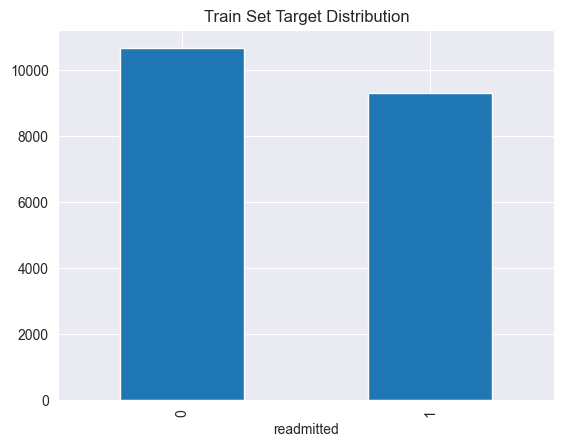

In [12]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

* The target looks relatively balanced, however in order to try and minimise overfitting oversampling will be performed.

In [13]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21360, 13) (21360,) (5000, 13) (5000,)


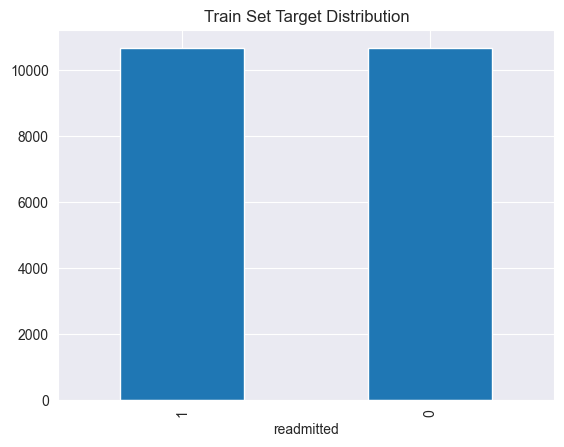

In [14]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### Grid Search CV - Sklearn

In [15]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "LogisticRegression": {}
}

Using default hyperparameters to find best algorithm, scored by recall (as per business requirement 2)

Quick GridSearch CV - Binary Classifier

In [16]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Results of GridSearch

In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.503277,0.543352,0.679775,0.068382
5,ExtraTreesClassifier,0.496723,0.542135,0.674625,0.06663
2,DecisionTreeClassifier,0.445693,0.517603,0.634363,0.062419
0,LogisticRegression,0.425562,0.46367,0.497191,0.026892
1,XGBClassifier,0.414326,0.43736,0.466292,0.018925
6,AdaBoostClassifier,0.388109,0.428652,0.457865,0.025524
4,GradientBoostingClassifier,0.373127,0.42191,0.45927,0.030332


The top two algorithms rated by mean score for recall were RandomForestClassifier and ExtraTreesClassifier.

Using these two algorithms, extensive hyperparameter optimization will be carried out.

#### Extensive search on the most suitable algorithms

In [18]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=42),
    # "ExtraTreesClassifier":ExtraTreesClassifier(random_state=42),
}

params_search = {
    "RandomForestClassifier":{'model__n_estimators': [250,500],
                            'model__max_depth': [15],
                            'model__min_samples_split': [2,50],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [5,30],
                            'model__class_weight': ['balanced'],
                            'model__max_features': ['sqrt',None],
                            },
#     "ExtraTreesClassifier":{'model__n_estimators': [250,500],
#                             'model__max_depth': [15,None],
#                             'model__min_samples_split': [2,50],
#                             'model__min_samples_leaf': [1,50],
#                             'model__max_leaf_nodes': [5,30],
#                             'model__class_weight': ['balanced'],
#                             'model__max_features': ['sqrt',None],
#                             }
}

In [19]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Results of GridSearch

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(10)

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
16,RandomForestClassifier,0.414326,0.600187,0.656367,0.093237,balanced,15,None,5,1,2,250
18,RandomForestClassifier,0.414326,0.600187,0.656367,0.093237,balanced,15,None,5,1,50,250
17,RandomForestClassifier,0.414326,0.599251,0.656367,0.092903,balanced,15,None,5,1,2,500
19,RandomForestClassifier,0.414326,0.599251,0.656367,0.092903,balanced,15,None,5,1,50,500
22,RandomForestClassifier,0.414326,0.593539,0.648408,0.09048,balanced,15,None,5,50,50,250
20,RandomForestClassifier,0.414326,0.593539,0.648408,0.09048,balanced,15,None,5,50,2,250
2,RandomForestClassifier,0.414326,0.591386,0.697097,0.095031,balanced,15,sqrt,5,1,50,250
0,RandomForestClassifier,0.414326,0.590918,0.695693,0.09464,balanced,15,sqrt,5,1,2,250
21,RandomForestClassifier,0.414326,0.59073,0.649345,0.089807,balanced,15,None,5,50,2,500
23,RandomForestClassifier,0.414326,0.59073,0.649345,0.089807,balanced,15,None,5,50,50,500


Save the best model and parameters

In [21]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [22]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': 15,
 'model__max_features': None,
 'model__max_leaf_nodes': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

Define the pipeline using the findings from hyperparameter optimisation

In [23]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        max_features=None, max_leaf_nodes=5,
                                        n_estimators=250, random_state=42))])

In [24]:
X_train.head()

,age,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change
0,0,47,0,21.0,0,1.0,0,0,0,0,0,0,1
1,1,50,1,11.0,0,0.0,0,1,1,1,0,0,0
2,2,66,1,10.0,0,0.0,0,0,0,1,0,1,0
3,2,63,0,28.0,0,0.0,0,2,1,1,1,0,0
4,2,60,2,25.0,3,2.0,4,0,2,0,0,0,1


### Feature Importance

With the optimal pipeline found, the importance of features to the model can be assessed using the **.feature_importances_** attribute.

* These are the 6 most important features in descending order. The model was trained on them: 
['n_medications', 'n_lab_procedures', 'diag_1', 'diag_2', 'age', 'diag_3']


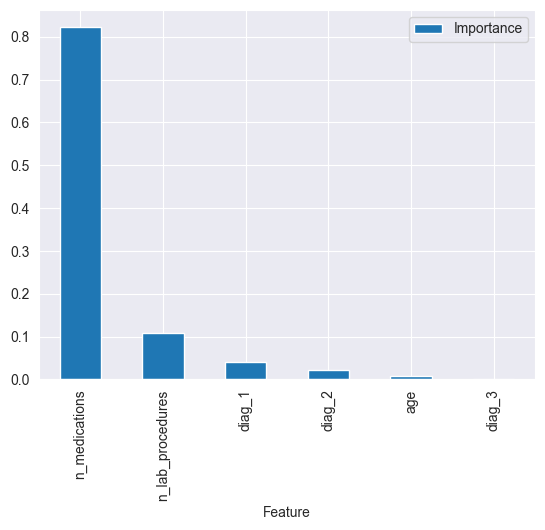

In [25]:
## Feature Importance from SelectFromModel
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test sets

In [26]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[["Actual " + sub for sub in label_map]],
        index=[["Prediction " + sub for sub in label_map]]
        ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [27]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Not Readmitted', 'Readmitted'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                          Actual Not Readmitted Actual Readmitted
Prediction Not Readmitted                  4734              3671
Prediction Readmitted                      5946              7009


---  Classification Report  ---
                precision    recall  f1-score   support

Not Readmitted       0.56      0.44      0.50     10680
    Readmitted       0.54      0.66      0.59     10680

      accuracy                           0.55     21360
     macro avg       0.55      0.55      0.54     21360
  weighted avg       0.55      0.55      0.54     21360
 

#### Test Set ####

---  Confusion Matrix  ---
                          Actual Not Readmitted Actual Readmitted
Prediction Not Readmitted                  1172               899
Prediction Readmitted                      1394              1535


---  Classification Report  ---
                precision    recall  f1-score   support

Not Readmitted       0.57      0.46      0

## Refit pipeline with best features

We can refit the ML pipeline with the most important features to determine whether we get the same result as one fitted with all variables.

In [69]:
best_features

Index(['n_medications', 'n_lab_procedures', 'diag_1', 'diag_2', 'age',
       'diag_3'],
      dtype='object')

#### Rewrite the ML Pipelines

In [70]:
def PipelineDataCleaningAndFeatureEngineeringBestFeatures():
    pipeline_base = Pipeline([
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',variables=[
            'age', 'diag_1', 'diag_3', 'diag_2'])),
        ('Winsorizer_iqr', Winsorizer(variables=['n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
    ])

    return pipeline_base

In [71]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

#### Split Train and Tests Sets Using Only Most Important Features

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['readmitted'], axis=1),
    df['readmitted'],
    test_size=0.3,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(17500, 15) (17500,) (7500, 15) (7500,)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med
15705,[80-90),4,70,0,6,0,7,0,Circulatory,Circulatory,Circulatory,no,no,0,1
6016,[70-80),6,52,1,8,0,0,0,Injury,Diabetes,Other,no,no,0,1
24764,[80-90),6,49,1,13,0,0,0,Circulatory,Circulatory,Respiratory,no,no,1,1
11962,[50-60),2,55,0,6,2,0,0,Other,Other,Diabetes,no,no,1,1
15824,[70-80),4,62,0,14,0,0,0,Digestive,Circulatory,Circulatory,no,no,0,1


In [80]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, X_test.shape)
X_train.head()

(17500, 6) (7500, 6)


,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
15705,6,70,Circulatory,Circulatory,[80-90),Circulatory
6016,8,52,Injury,Diabetes,[70-80),Other
24764,13,49,Circulatory,Circulatory,[80-90),Respiratory
11962,6,55,Other,Other,[50-60),Diabetes
15824,14,62,Digestive,Circulatory,[70-80),Circulatory


### Handle Target imbalance

In [81]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineeringBestFeatures()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(17500, 6) (17500,) (7500, 6) (7500,)


,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
15705,6.0,70,0,0,0,0
6016,8.0,52,1,1,1,1
24764,13.0,49,0,0,0,2
11962,6.0,55,2,2,2,3
15824,14.0,62,3,0,1,0


In [84]:
X_test.head()

,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
14149,5.0,17,4,2,1,1
8946,12.0,37,2,0,4,2
22378,15.0,43,3,4,0,3
12162,13.0,69,2,2,4,2
4879,11.0,58,2,2,0,3


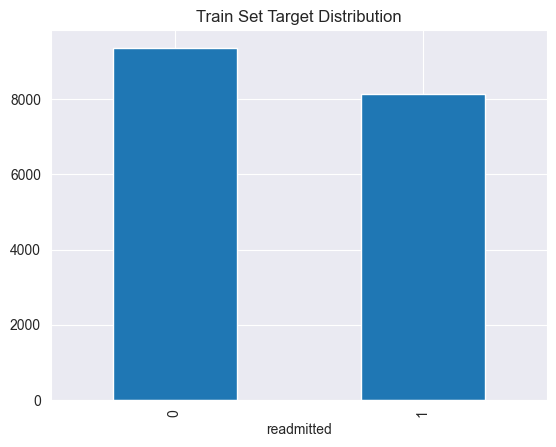

In [85]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [86]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18732, 6) (18732,) (7500, 6) (7500,)


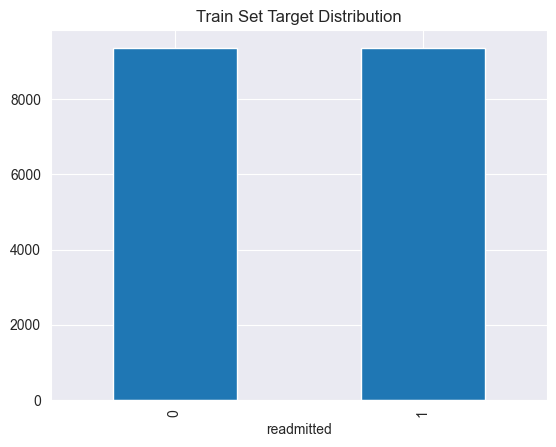

In [87]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### GridSearch CV

In [88]:
models_search = {'RandomForestClassifier': RandomForestClassifier(random_state=42)}

In [89]:
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': 15,
 'model__max_features': None,
 'model__max_leaf_nodes': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

In [90]:
params_search = {"RandomForestClassifier":{'model__class_weight': ['balanced'],
                                        'model__max_depth': [15],
                                        'model__max_features': [None],
                                        'model__max_leaf_nodes': [5],
                                        'model__min_samples_leaf': [1],
                                        'model__min_samples_split': [2],
                                        'model__n_estimators': [250]
                                        }
                }

In [91]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                scoring=make_scorer(recall_score, pos_label=1),
                n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Checking the results

In [92]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.607048,0.631326,0.663107,0.02166,balanced,15,None,5,1,2,250


Defining the best classification pipeline

In [93]:
best_model = grid_search_summary.iloc[0, 0]

pipeline_clf_pca = grid_search_pipelines[best_model].best_estimator_
pipeline_clf_pca

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        max_features=None, max_leaf_nodes=5,
                                        n_estimators=250, random_state=42))])

In [94]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__class_weight': 'balanced',
 'model__max_depth': 15,
 'model__max_features': None,
 'model__max_leaf_nodes': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

### Assess feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['diag_1', 'n_lab_procedures', 'diag_2', 'age', 'n_medications', 'diag_3']


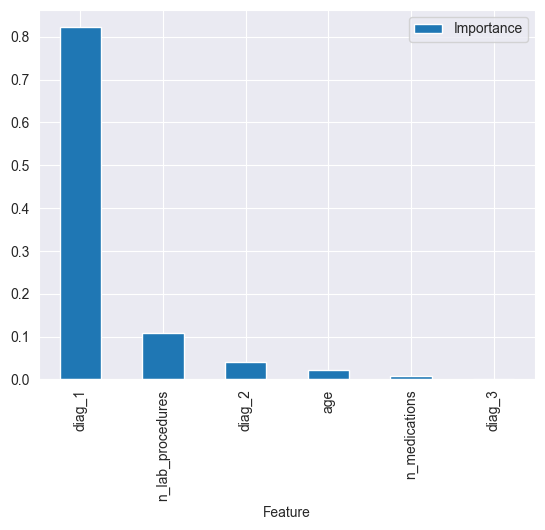

In [95]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [96]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Not readmitted', 'readmitted'] 
                )

#### Train Set #### 



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- A1Ctest
- change
- glucose_test
- n_emergency
- n_inpatient
- ...


---

## Refit pipeline using PCA

In [ ]:
def PipelineDataCleaningAndFeatureEngineeringPCA():
    pipeline_base = Pipeline([
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',variables=categorical_columns)),
        ('Winsorizer_iqr', Winsorizer(variables=[
            'time_in_hospital', 'n_procedures','n_inpatient', 'n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        method="spearman", threshold=0.4, selection_method="variance")),
    ])

    return pipeline_base

In [ ]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=13, random_state=0)),
        ("model", model),
    ])

    return pipeline_base

Split to train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['readmitted'], axis=1),
    df['readmitted'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#### Handle Target Imbalance

In [ ]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineeringPCA()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [ ]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

#### GridSearch 

In [ ]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "LogisticRegression": {}
}

In [ ]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Extensive research

In [ ]:
models_quick_search = {
    # "RandomForestClassifier":RandomForestClassifier(random_state=42),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=42),
}

params_quick_search = {
    # "RandomForestClassifier":{'model__n_estimators': [250,500],
    #                         'model__max_depth': [15,None],
    #                         'model__min_samples_split': [2,50],
    #                         'model__min_samples_leaf': [1,50],
    #                         'model__max_leaf_nodes': [5,30],
    #                         'model__class_weight': ['balanced'],
    #                         'model__max_features': ['sqrt',None],
    #                         },
    "ExtraTreesClassifier":{'model__n_estimators': [250,500],
                            'model__max_depth': [15,None],
                            'model__min_samples_split': [2,50],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [5,30],
                            'model__class_weight': ['balanced'],
                            'model__max_features': ['sqrt',None],
                            }
}

In [ ]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

#### Assess features importance

In [ ]:
## PCA 
pca = pipeline_clf['PCA']
model = pipeline_clf['model']
# Get the PCA components (coefficients of original features)
components = pca.components_
# Get the feature names
feature_names = X_train.columns

# Calculate the importance of original features by multiplying the component coefficients
# with the feature importances from the model (if the model has such an attribute)
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': components.T @ model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

#### Evaluate Pipeline on Train and Test sets

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Not readmitted', 'readmitted'] 
                )

---

# Push files to Repo

We will generate the following files:

* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [97]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_readmission/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

### Train Set

In [99]:
print(X_train.shape)
X_train.head()

(18732, 6)


,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
0,6.0,70,0,0,0,0
1,8.0,52,1,1,1,1
2,13.0,49,0,0,0,2
3,6.0,55,2,2,2,3
4,14.0,62,3,0,1,0


In [98]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [100]:
y_train

0        0
1        1
2        0
3        1
4        0
        ..
18727    1
18728    1
18729    1
18730    1
18731    1
Name: readmitted, Length: 18732, dtype: int64

In [101]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

In [102]:
print(X_test.shape)
X_test.head()

(7500, 6)


,n_medications,n_lab_procedures,diag_1,diag_2,age,diag_3
14149,5.0,17,4,2,1,1
8946,12.0,37,2,0,4,2
22378,15.0,43,3,4,0,3
12162,13.0,69,2,2,4,2
4879,11.0,58,2,2,0,3


In [103]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [104]:
y_test

14149    1
8946     1
22378    1
12162    0
4879     1
        ..
3639     0
3338     1
10927    1
23669    1
6492     1
Name: readmitted, Length: 7500, dtype: int64

In [105]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines:

* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.

Pipeline responsible for Data Cleaning and Feature Engineering.

In [106]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('OrdinalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['age', 'diag_1', 'diag_3',
                                           'diag_2'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['n_medications', 'n_lab_procedures']))])

In [107]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_readmission/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

In [108]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        max_features=None, max_leaf_nodes=5,
                                        n_estimators=250, random_state=42))])

In [109]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_readmission/v1/clf_pipeline_model.pkl']

## Feature Importance plot

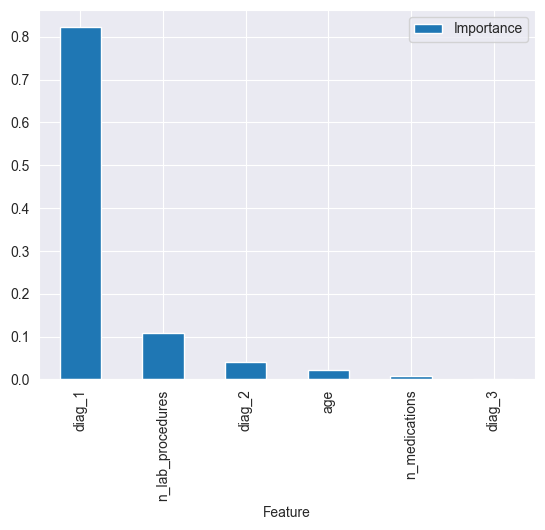

In [110]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

## Conclusions